In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython import display

display.set_matplotlib_formats('svg')

/tmp/ipykernel_249648/2400937917.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Logistic Regression as ANN

The binary logistic regression model is defined as:

$$
\begin{align*}
y_i & \sim \text{Binomial}(1, p_i) \\
\text{logit}(p_i) & = \beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}
\end{align*}
$$

where $y_i$ is the binary response variable, $p_i$ is the probability of $y_i = 1$, and $x_{ij}$ are the predictor variables. In statistics courses you may have encountered the Maximum Likehood Estimation (MLE) method to estimate the coefficients $\beta_j$. The likelihood function of the model (assuming independence of the observations) is:

$$
\begin{align*}
L(\beta) & = \prod_{i=1}^n p_i^{y_i} (1 - p_i)^{1 - y_i} \\
\log L(\beta) & = \sum_{i=1}^n y_i \log(p_i) + (1 - y_i) \log(1 - p_i)
\end{align*}
$$

The MLE method estimates the coefficients $\beta_j$ by maximizing the log-likelihood function. This is usually done using optimization algorithms like [Newton-Raphson](https://personal.math.ubc.ca/~anstee/math104/newtonmethod.pdf) which is implemented in R's `glm` function.

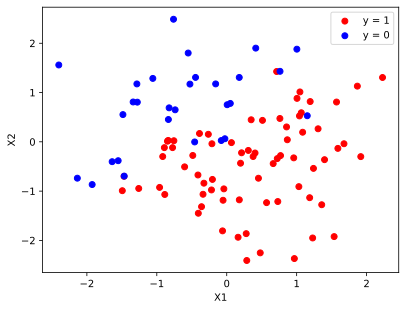

In [2]:
# Generate some fake data for demonstration
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

n = 100
p = 2

X = np.random.randn(n, p)
beta = np.array([1.7, -2])

def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

probs = sigmoid(X @ beta + 1)
y = np.random.binomial(1, probs)

# Plot the data 

plt.scatter(X[y.squeeze() == 1, 0], X[y.squeeze() == 1, 1], color='red', label='y = 1')
plt.scatter(X[y.squeeze() == 0, 0], X[y.squeeze() == 0, 1], color='blue', label='y = 0')
plt.legend()
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [3]:
logreg = LogisticRegression(penalty=None, fit_intercept=True)
logreg.fit(X, y.squeeze())
print(logreg.coef_)

[[ 2.90668154 -3.78267065]]


In [4]:
beta.T

array([ 1.7, -2. ])

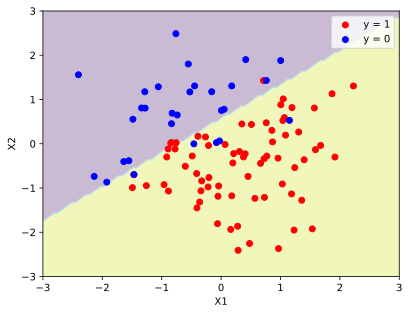

In [5]:
# Plot the decision boundary

x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)

X1, X2 = np.meshgrid(x1, x2)
X_grid = np.c_[X1.ravel(), X2.ravel()]
y_grid = logreg.predict(X_grid).reshape(X1.shape)

plt.contourf(X1, X2, y_grid, alpha=0.3)
plt.scatter(X[y.squeeze() == 1, 0], X[y.squeeze() == 1, 1], color='red', label='y = 1')
plt.scatter(X[y.squeeze() == 0, 0], X[y.squeeze() == 0, 1], color='blue', label='y = 0')
plt.legend()
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

## Logistic Regression as a ANN

As the linear regression model, the logistic regression model can be seen as a single-layer artificial neural network. The model is defined as:

$$
\hat{y}_i = \sigma(b + w_1 x_{i1} + \ldots + w_p x_{ip}) = \sigma(b + w^T x_i)
$$

The predictions are again made using the dot product of the input features and the weights, plus a bias term. The difference is that the output is passed through the sigmoid function, which maps the output to the interval $[0, 1]$. The sigmoid function is defined as:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$


```{mermaid}
%%| label: fig-single-neuron
%%| fig-width: 6
%%| fig-cap: "ANN model for linear regression for a single observation"

graph LR
    x1["$$x_{i1}$$"] -->|$$w_1$$| B(($$w^T x_i + b$$))
    x2["$$x_{i2}$$"] -->|$$w_2$$| B
    xp["$$x_{ip}$$"] -->|$$w_p$$| B
    B --> |"$$\sigma$$"|C["$$\hat{y}$$"]
```

The loss function for logistic regression is the binary cross-entropy:

$$
L_i = -y_i \log(\hat{y}_i) - (1 - y_i) \log(1 - \hat{y}_i)
$$

Its derivative with respect to the weights is:

$$
\frac{\partial L_i}{\partial w_j} = (y_i - \hat{y}_i) x_{ij}
$$

and with respect to the bias:

$$
\frac{\partial L_i}{\partial b} = (y_i - \hat{y}_i)
$$

:::{.callout-note}
## Derivative of the Sigmoid Function

The derivative of the sigmoid function is:

$$
\sigma'(z) = \sigma(z) (1 - \sigma(z))
$$
:::



Using these gradients, we can derive the update rules for the weights and the bias:

$$
w^{t + 1}_j = w^{t}_j + \eta \sum_i (y_i - \hat{y}_i) x_{ij}
$$

$$
b^{t + 1} = b^{t} + \eta \sum_i (y_i - \hat{y}_i)
$$

where $\eta$ is the learning rate.



## Vectorized Weight Update

Computationally it is much faster if we update a whole weight matrix at once, rather than updating each weight individually. 

Consider a very simple example with two inputs and one observation. The weight matrix must be of size $2 \times 1$ as it must map the two input features to a single output. The weight matrix is defined as:

$$
W = \begin{bmatrix} w_1 \\ w_2 \end{bmatrix}
$$

The input vector (because we have only one observation) is:

$$
X = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}
$$

where $x_1$ and $x_2$ are the input features, do not confuse them with values of the input features for different observations. The output layer receives the dot product of the input vector and the weight matrix, plus the bias term and passes it through the sigmoid function to produce the prediction (a single probability).

$$
\hat{y} = \sigma(W^T X + b)
$$


:::{.callout-note collapse="true"}
## Cross-Entropy in the Binary Case

For multi-class classification the usual loss function is the cross-entropy (@def-cross-entropy-loss). In the binary case, the cross-entropy simplifies to:

$$
L = -y \log(\hat{y}) - (1 - y) \log(1 - \hat{y})
$$

where $y$ is one if the observation belongs to the target class and zero otherwise (belongs to the reference class). The prediction $\hat{y}$ is a probability that the observation belongs to the target class.

The general form of the cross-entropy loss is:

$$
L = -\sum_{k=1}^K y_k \log(\hat{y}_k)
$$

and for two classes ($K = 2$) we can write it as:

$$
L = -y_1 \log(\hat{y}_1) - y_2 \log(\hat{y}_2)
$$

Because there are only two classes, the predicted probabilities must sum to one: 

$$
\hat{y}_1 + \hat{y}_2 = 1
$$

The indicator variables also need to sum to one, because the observation can belong to only one class:

$$
y_1 + y_2 = 1
$$

We can use this fact to simplify the cross-entropy loss:

$$
L = -y_1 \log(\hat{y}_1) - (1 - y_1) \log(1 - \hat{y}_1)
$$

As we only have two classes, we often suppress the notation that distinguishes between the two classes and use a single variable $y$ to denote the target class. The loss function then simplifies to:

$$
L = -y \log(\hat{y}) - (1 - y) \log(1 - \hat{y})
$$
:::

The derivative of the loss function with respect to the weights is:

$$
\frac{\partial L}{\partial W} = \underbrace{(y - \hat{y})}_{1 \times 1} \underbrace{X^T}_{1 \times P} = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \begin{bmatrix} y - \hat{y} \end{bmatrix} = \begin{bmatrix} (y - \hat{y})x_1 \\ (y - \hat{y})x_2 \end{bmatrix}
$$

where $K$ is the number of classes and $P$ is the number of input features. The derivative with respect to the bias is:

$$
\frac{\partial L}{\partial b} = y - \hat{y}
$$



In [6]:
# Fit a logistic regression model using PyTorch

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

logreg_ann = nn.Sequential(
    nn.Linear(p, 1),
    nn.Sigmoid()
)

losses = []

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(logreg_ann.parameters(), lr=0.02)

for i in range(20000):
    y_pred = logreg_ann(X_tensor).squeeze()
    loss = criterion(y_pred, y_tensor)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f'Iteration {i}, loss = {loss.item()}')
    

Iteration 0, loss = 0.4373357892036438
Iteration 100, loss = 0.38030555844306946
Iteration 200, loss = 0.3471527397632599
Iteration 300, loss = 0.32525181770324707
Iteration 400, loss = 0.3095771372318268
Iteration 500, loss = 0.29773929715156555
Iteration 600, loss = 0.2884514331817627
Iteration 700, loss = 0.28095459938049316
Iteration 800, loss = 0.27476969361305237
Iteration 900, loss = 0.26957786083221436
Iteration 1000, loss = 0.2651573717594147
Iteration 1100, loss = 0.2613492012023926
Iteration 1200, loss = 0.2580357789993286
Iteration 1300, loss = 0.2551281750202179
Iteration 1400, loss = 0.2525578737258911
Iteration 1500, loss = 0.2502709627151489
Iteration 1600, loss = 0.24822461605072021
Iteration 1700, loss = 0.24638427793979645
Iteration 1800, loss = 0.24472150206565857
Iteration 1900, loss = 0.24321311712265015
Iteration 2000, loss = 0.2418397068977356
Iteration 2100, loss = 0.24058496952056885
Iteration 2200, loss = 0.239435076713562
Iteration 2300, loss = 0.23837833106

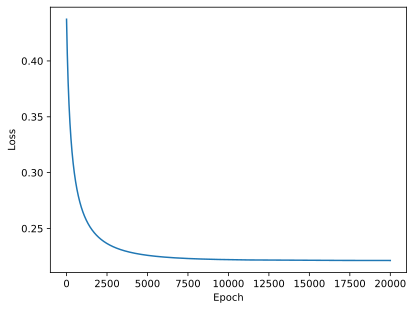

In [7]:
# Plot the loss curve

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [8]:
# Extract the weights from the model

weights = [param.data.numpy() for param in logreg_ann.parameters()]
weights

[array([[ 2.848236, -3.705618]], dtype=float32),
 array([2.123958], dtype=float32)]

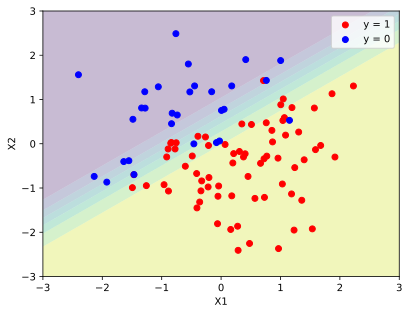

In [9]:
# Plot the decision boundary

x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)

X1, X2 = np.meshgrid(x1, x2)
X_grid = np.c_[X1.ravel(), X2.ravel()]
X_grid_tensor = torch.tensor(X_grid, dtype=torch.float32)
y_grid = logreg_ann(X_grid_tensor).detach().numpy().reshape(X1.shape)

plt.contourf(X1, X2, y_grid, alpha=0.3)
plt.scatter(X[y.squeeze() == 1, 0], X[y.squeeze() == 1, 1], color='red', label='y = 1')
plt.scatter(X[y.squeeze() == 0, 0], X[y.squeeze() == 0, 1], color='blue', label='y = 0')
plt.legend()
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [10]:
# Exercise: Implement the logistic regression model using `numpy`. See how the linear regression
# model was implemented in the previous section for guidance.

def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

sigmoid(np.array([1, 2, 3]))


array([0.73105858, 0.88079708, 0.95257413])

In [15]:
np.exp(1) ** (-1)

0.36787944117144233

In [16]:
np.exp(-1)

0.36787944117144233

In [12]:
1 / (1 + np.exp(-1))

NameError: name 'e' is not defined

In [54]:
# w

array([ 1.74152592, -1.8398871 ])

In [55]:
# b

array([0.9719365])

In [56]:
# logreg.coef_

array([[ 1.54237797, -1.85846244]])